# Some useful presentations

https://github.com/data-mining-in-action/DMIA_Sport_2019_Autumn/tree/master/lectures

# Create dataset with all unique combinations of given columns

In [ ]:
from itertools import product

index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in df['date_block_num'].unique():
    cur_shops = sales_train[sales_train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales_train[sales_train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales_train.groupby(index_cols, as_index=False).agg({'item_cnt_day': 'sum'})

#join aggregated data to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)
#sort the data
all_data.sort_values(['date_block_num', 'shop_id', 'item_id'],inplace=True)

# Add calendar features

In [ ]:
import math
import calendar
import holidays
import datetime

date_blocks = pd.DataFrame(sales_train2.date_block_num.drop_duplicates())

def add_month(col):
    return int(divmod(col, 12)[1] + 1)

def add_year(col):
    return int(2013 + divmod(col+1, 12)[0])

def add_year_month(row):
    return f'{row.year}-{row.month}'

def add_season(col):
    if 0 < col <= 2 or col == 12:
        return 'winter'
    if 3 <= col < 6:
        return 'spring'
    if 6 <= col < 9:
        return 'summer'
    if 9 <= col < 12:
        return 'autumn'
    return np.nan

# get number of holidays + weekend in each month    
ru_holidays = []

for date, name in sorted(holidays.RU(years=[2013, 2014, 2015]).items()):
    ru_holidays.append(date)
    
def add_holidays_and_weekends(row):
    busines_dates = pd.bdate_range(f"{row.year}-{row.month}-01", f"{row.year}-{row.month}-{row.days_in_month}")
    busines_dates = [b for b in busines_dates if b not in ru_holidays]
    return row.days_in_month - len(busines_dates)
    
def add_weeks_in_month(row):
    for i in range(1, row.days_in_month+1):
        d = datetime.datetime(row.year, row.month, i)
        if d.day > d.weekday():
            startdate = d
            break
    return ((datetime.datetime(row.year, row.month, row.days_in_month) - startdate).days) //7 + 1 
    
def create_calendar_features(data):
    data['month'] = data.date_block_num.apply(add_month) 
    data['year'] = data.date_block_num.apply(add_year)
    data['year_month'] = data.apply(add_year_month, axis=1)
    data.year_month = pd.to_datetime(data.year_month, format='%Y-%m')
    data['days_in_month'] = data.year_month.dt.daysinmonth
    data['weeks_in_month'] = data.apply(add_weeks_in_month, axis=1)
    data['season'] = data.month.apply(add_season)
    data['holidays_and_weekends_in_month'] = data.apply(add_holidays_and_weekends, axis=1)


create_calendar_features(date_blocks)

# Create group features

In [ ]:
def create_gr_feats(data):
    # create aggregation feats for numeric features based on categorical ones
    for cat_col in ['shop_id', 'item_category_id', 'city', 'item_id']:
        for num_col in ['item_cnt_month', 'item_price']:
            for n, f in [('mean', np.mean), ('min', np.nanmin), ('max', np.nanmax)]:
                data[n + '_' + num_col + '_by_' + cat_col] = sales_train2.groupby(cat_col)[num_col].transform(f)
                
    # create features with counts
    for col in ['shop_id', 'item_id', 'item_category_id', 'city', 'global_category', 'item_price']:
        data[col + '_cnt'] = data[col].map(sales_train2[col].value_counts(dropna = False))

# Replace rare values with "RARE VALUE" string

In [ ]:
def create_col_with_min_freq(data, col, min_freq=10):
    # replace rare values (less than min_freq rows) in feature by RARE_VALUE
    data[col + '_fixed'] = data[col].astype(str)
    data.loc[sales_train2[col].value_counts()[data[col + '_fixed']].values < min_freq, col + 
             '_fixed'] = "RARE_VALUE"


# Get data from previous month(s) for timeseries prediction

In [ ]:
mean_cols = [c for c in sales_train2.columns if c.startswith('mean_item_cnt', 0, 13)] + ['item_cnt_month']

def create_time_features():
    global sales_train2, sales_test2
    win = [i for i in range(1, 4)]
    for w in win:
        tmp = sales_train2[['date_block_num', 'shop_id', 'item_id'] + mean_cols].copy()
        tmp.date_block_num = tmp.date_block_num + w
        for c in mean_cols:
            tmp.rename({c: c + str(w)}, axis=1, inplace=True)

        sales_train2 = sales_train2.join(tmp.set_index(['date_block_num', 'shop_id', 'item_id']), 
                                         on=['date_block_num', 'shop_id', 'item_id'])
        sales_test2 = sales_test2.join(tmp.set_index(['date_block_num', 'shop_id', 'item_id']), 
                                       on=['date_block_num', 'shop_id', 'item_id'])
        del tmp
        gc.collect()

# Sort features according to their std, skewness and kurtosis

May be usefull for finding some interesting features

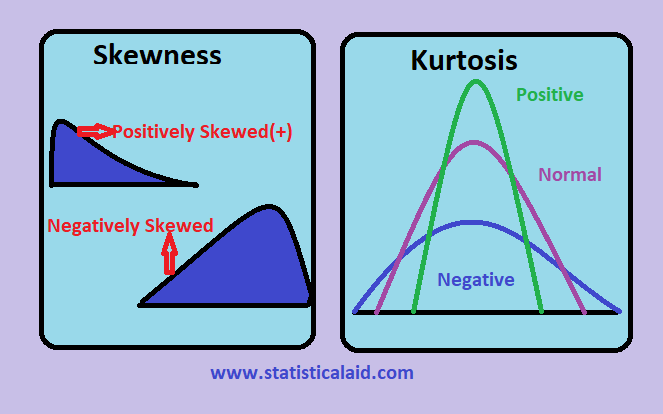

In [2]:
num_cols = ['Age', 'Income']

features_std = df.loc[:, num_cols].apply(lambda x: np.std(x)).sort_values(ascending=False)
f_std = df[features_std.iloc[:20].index.tolist()]

with pd.option_context('mode.use_inf_as_na', True): # mode.use_inf_as_na means treat infinities as NaN
    features_skew = np.abs(df.loc[:,num_cols].apply(lambda x: np.abs(skew(x))).sort_values(
        ascending=False)).dropna()
skewed = df[features_skew.iloc[:20].index.tolist()]

with pd.option_context('mode.use_inf_as_na', True):
    features_kurt = np.abs(df.loc[:,num_cols].apply(lambda x: np.abs(kurtosis(x))).sort_values(
        ascending=False)).dropna()
kurt_f = df[features_kurt.iloc[:20].index.tolist()]